In [16]:
import numpy as np
from scipy import sparse
import pylab as plt
from sklearn import datasets
from scipy.optimize import linprog

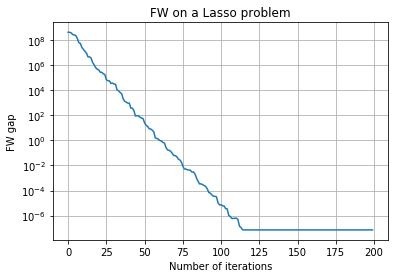

Sparsity of solution: 0.1%


In [3]:
'''from Fabian Pedregosa'''
def FW(alpha, max_iter=200, tol=1e-8):
    # .. initial estimate, could be any feasible point ..
    x_t = sparse.dok_matrix((n_features, 1))
    trace = []  # to keep track of the gap

    # .. some quantities can be precomputed ..
    Atb = A.T.dot(b)
    for it in range(max_iter):
        # .. compute gradient. Slightly more involved than usual because ..
        # .. of the use of sparse matrices ..
        Ax = x_t.T.dot(A.T).ravel()
        grad = (A.T.dot(Ax) - Atb)

        # .. the LMO results in a vector that is zero everywhere except for ..
        # .. a single index. Of this vector we only store its index and magnitude ..
        idx_oracle = np.argmax(np.abs(grad))
        mag_oracle = alpha * np.sign(-grad[idx_oracle])
        g_t = x_t.T.dot(grad).ravel() - grad[idx_oracle] * mag_oracle
        trace.append(g_t)
        if g_t <= tol:
            break
        q_t = A[:, idx_oracle] * mag_oracle - Ax
        step_size = min(q_t.dot(b - Ax) / q_t.dot(q_t), 1.)
        x_t = (1. - step_size) * x_t
        x_t[idx_oracle] = x_t[idx_oracle] + step_size * mag_oracle
    return x_t, np.array(trace)

n_samples, n_features = 1000, 10000
A, b = datasets.make_regression(n_samples, n_features)
# .. plot evolution of FW gap ..
sol, trace = FW(.5 * n_features)
plt.plot(trace)
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('FW gap')
plt.title('FW on a Lasso problem')
plt.grid()
plt.show()

sparsity = np.mean(sol.toarray().ravel() != 0)
print('Sparsity of solution: %s%%' % (sparsity * 100))

In [4]:
'''frank wolfe functions'''
def gradient(F, x):
    return None

def linear_program_oracle(F, x):
    return None

def frank_wolfe(F, x, max_iter=200, alpha=0.1, tol=1e-8):
    for k in range(max_iter):
        grad = gradient()
        x_hat = linear_program_oracle()
        x = x + alpa*(x_hat - x)
    return x

In [17]:
'''Linear Programming'''
# f(x0,x1) = -x0 + 4x1
c = [-1, 4]
A = [[-3, 1], [1, 2]]
b = [6, 4]
x0_bounds = (None, None)
x1_bounds = (-3, None)
res = linprog(c, A_ub=A, b_ub=b, bounds=[x0_bounds, x1_bounds])
print(res)

     con: array([], dtype=float64)
     fun: -22.0
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([3.90000000e+01, 1.77635684e-15])
  status: 0
 success: True
       x: array([10., -3.])


In [100]:
#gradient test
f = lambda x: x[0]**2 + x[1]**2
c = 1e-10
x = np.array([1,2])


def grad_KWSA(F, x, c, d):
    grad = 0
    e = np.zeros(d)
    for i in range(d):
        e[i] = 1 #cb-vector
        grad += ((F(x + c*e) - F(x))/c)*e #calculate the gradient
        e[i] = 0 #reset cb-vector
    return grad

def grad_RDSA(F, x, c, d):
    z = np.random.normal(0, 1, size=(d)) #mean = 0, std = 1
    grad = ((F(x + c*z) - F(x))/c)*z
    return grad

def grad_IRDSA(F, x, c, d, m=5):
    grad = 0
    for i in range(m):
        z = np.random.normal(0, 1, size=(d)) #mean = 0, std = 1
        grad += ((F(x + c*z) - F(x))/c)*z
    return grad/m

print("KWSA", grad_KWSA(f, x, c, len(x)))
print("RDSA", grad_RDSA(f, x, c, len(x)))
print("IRDSA", grad_IRDSA(f, x, c, len(x)))

KWSA [2.00000017 4.00000033]
RDSA [ 0.3296272  -0.05099195]
IRDSA [1.29353959 4.13706488]


In [92]:
'''Zeroth Order Frank Wolfe [Sahu et al]'''
'''Stochastic Gradient Free Frank Wolfe - Convex'''
def SGF_frank_wolfe_cvx(F, x, max_iter=200, mode="KWSA"):
    dim = len(x)
    t = np.arange(max_iter) # sequence of t = 0,1,....max_iter
    gamma = 2/(t + 8) # initialize gamma sequences
    # rho and c sequences:
    rho = c = None
    if mode == "KWSA":
        rho = 4/((t+8)**(2/3))
        c = 2/((d**(1/2)) * ((t + 8)**(1/3)))
    elif mode == "IRDSA":
        rho = 4/(((1 + (d/m))**(1/3)) * ((t+8)**(2/3)))
        c = 2*np.sqrt(m)/(d**(3/2) * (t+8)**(1/3))
    elif mode == "RDSA":
        rho = 4/(d**(1/3) * (t+8)**(2/3))
        c = 2/(d**(3/2) * (t+8)**(1/3))
    d = 0 #initial value d_0 = 0
    for i in t: #loop
        grad = 0
        if mode == "KWSA":
            grad = grad_KWSA(F, x, c[i], dim)
        elif mode == "IRDSA":
            grad = grad_IRDSA(F, x, c[i], dim)
        elif mode == "RDSA":
            grad = grad_RDSA(F, x, c[i], dim)
        d = (1-rho[i])*d + rho[i]*grad #used for linear programming oracle (LPO)
        
        v = linear_program_oracle(d) ### LPO
        
        x = (1-gamma[i])*x + gamma[i]*v
    return x

In [94]:
2/(np.arange(10)+8)

array([0.25      , 0.22222222, 0.2       , 0.18181818, 0.16666667,
       0.15384615, 0.14285714, 0.13333333, 0.125     , 0.11764706])

In [106]:
np.dot([1,2,3],[2,4,6])

28